Run to set up for visualizations

In [78]:
!pip install mrcfile
import mrcfile
!pip install numpy
import numpy as np
import pickle
!pip install opencv-python
!pip install matplotlib
import random
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import os
!pip install configmypy
from configmypy import ConfigPipeline, YamlConfig, ArgparseConfig
from scipy.ndimage import affine_transform
import torch
from scipy.ndimage import zoom
import yaml
import pickle

from d3_reconstruction import get_volume
from utils import visualize_3D, visualize_2D, fft, ifft, hartley_transform, generate_rand_axis, get_rotation_matrix, rotate_arbitrary_axis

Visualization of 3D Protein in Real Space

In [ ]:
mrc_file_path = "/path/to/your/directory/data/vols/000.mrc"

with mrcfile.open(mrc_file_path, permissive=True) as mrc:
    protein_raw = mrc.data
    visualize_3D(128, protein_raw, 0.3, 130, "Real Protein Volume Visualization")

Visualization of Projections of the Protein in Real Space

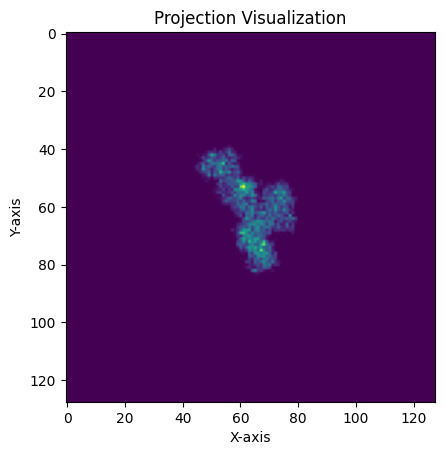

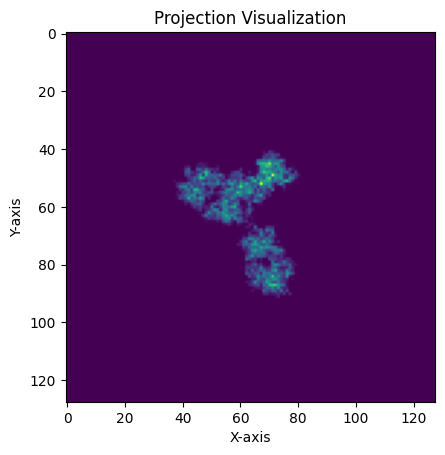

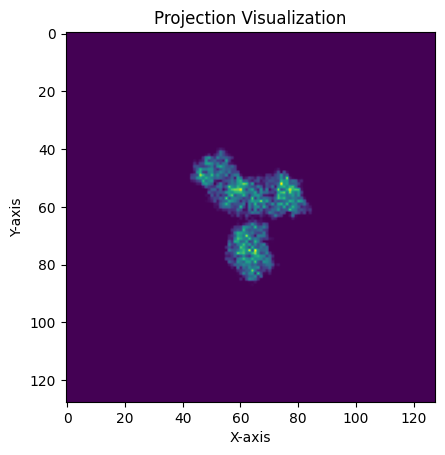

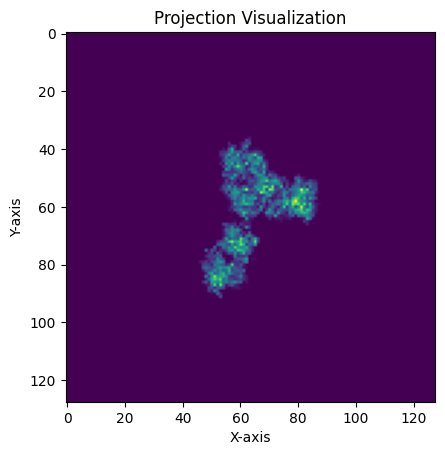

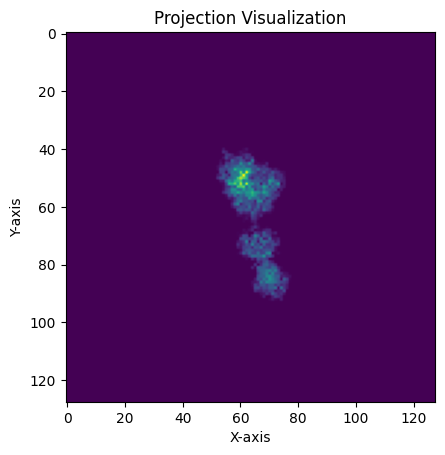

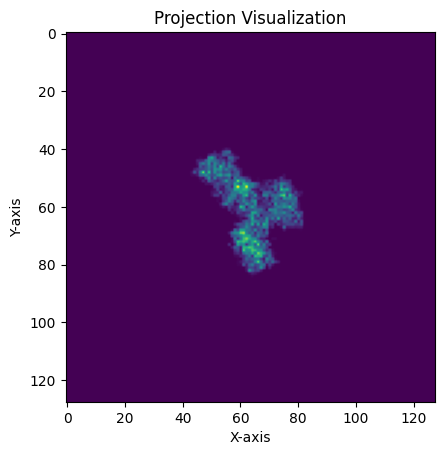

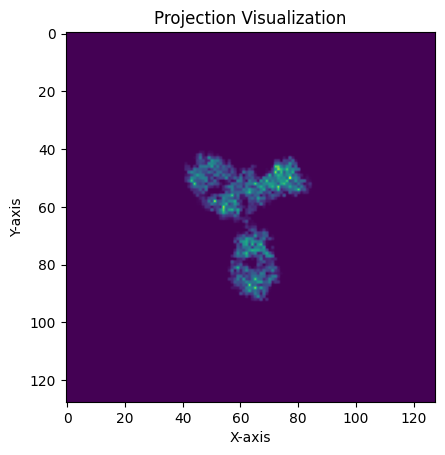

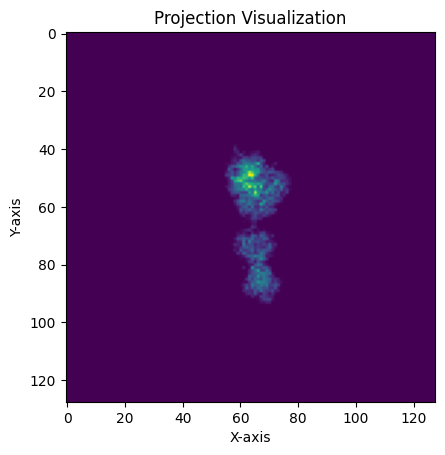

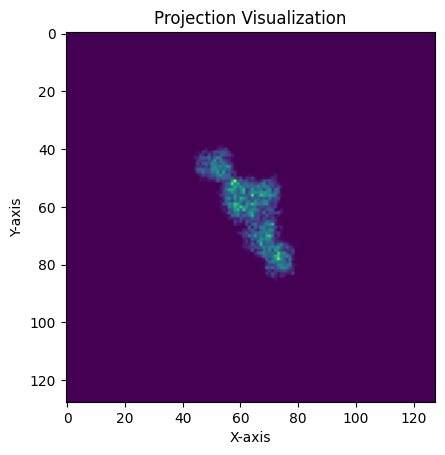

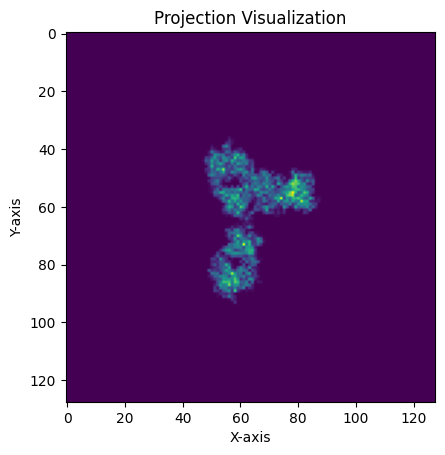

In [76]:
projections = open('/path/to/your/directory/data/slices_000.pkl', 'rb')
projections = pickle.load(projections)

num_plot = 10 # change as desired

for projection in projections[:num_plot]: 
    data2D = projection
    visualize_2D(data2D, "Projection Visualization")

3D Reconstruction given 2D projections 

In [ ]:
projections = open('/path/to/your/directory/data/slices_000.pkl', 'rb')
rotations = open('/path/to/your/directory/data/rotations_000.pkl', 'rb')

projections = pickle.load(projections)
rotations = pickle.load(rotations)

images_fourier = []
used_rotations = []

slices = []

num_slices = 10
skip_factor = len(projections) // num_slices
D = 50

for projection, pose in zip(projections[::skip_factor], rotations[::skip_factor]): 
    data2D = projection
    data2D = cv2.resize(projection, (D, D), interpolation=cv2.INTER_CUBIC)
    slices.append(data2D)
    used_rotations.append(pose)

fvol = get_volume(50, used_rotations, slices, False)
visualize_3D(50, ifft(fvol), 0.3, 130, "3D reconstruction")

Fourier Slice Theorem Proof

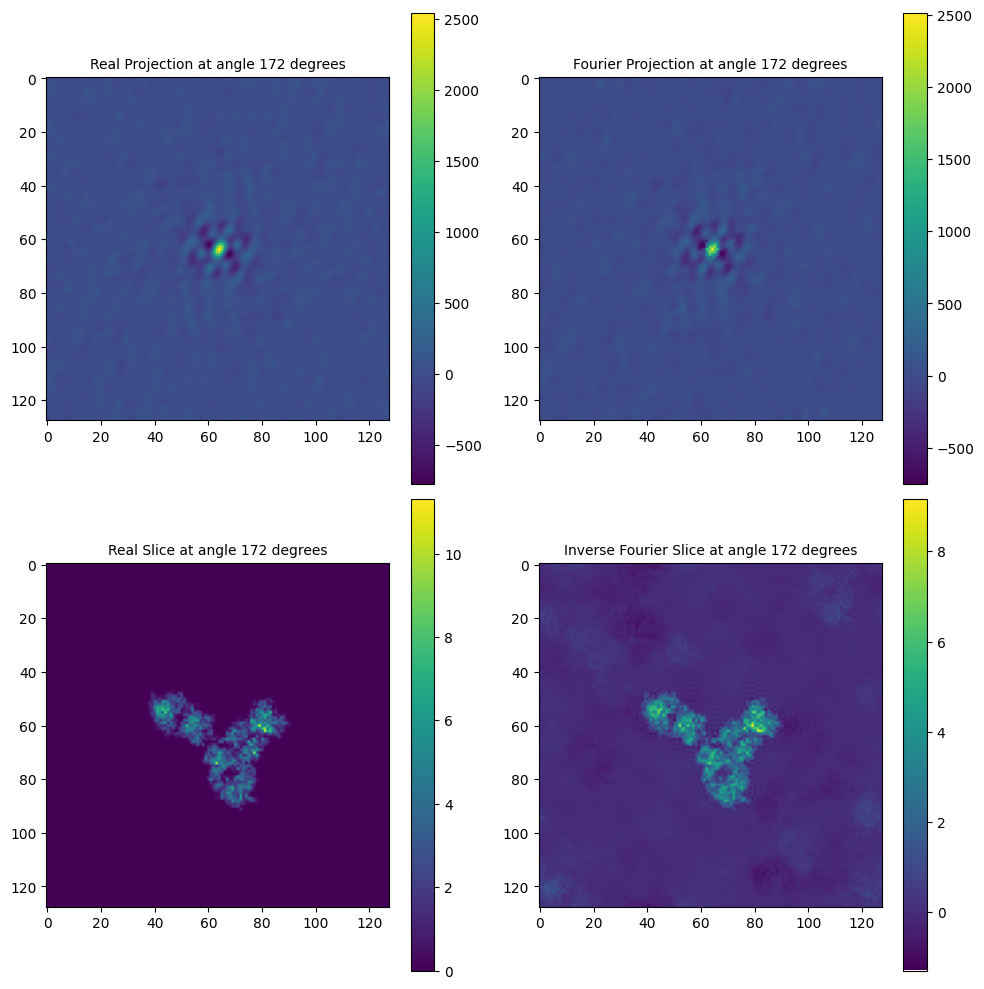

In [44]:
thetas = np.linspace(0, 360, num=100, endpoint=False, dtype=int)
np.random.shuffle(thetas)
slices = []
projections = []
rotation_matrices = []
D = 128

fprotein = fft(protein_raw)

for theta in thetas:
    random_axis = generate_rand_axis(3)
    R = get_rotation_matrix(theta, random_axis)
    rotation_matrices.append(R)

    f_rotated_protein = rotate_arbitrary_axis(fprotein, R, order=0)
    fourier_slice = f_rotated_protein[:, :, D // 2]
    slices.append(fourier_slice)

    projection = rotate_arbitrary_axis(protein_raw, R, order=0).sum(axis = 2)
    projections.append(projection)


num_rows = 2 
num_cols = 2 
num_plot = 1  # Number of iterations to plot (change as needed)

for i in range(num_plot):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))  # Adjust figsize for clarity
    
    # First plot: Fourier-transformed projection
    ax1 = axes[0, 0]
    im1 = ax1.imshow(np.fft.fftshift(np.fft.fftn(np.fft.fftshift(projections[i]))).real)
    ax1.set_title(f"Real Projection at angle {thetas[i]} degrees", fontsize=10)
    plt.colorbar(im1, ax=ax1)

    # Second plot: Slice in Fourier Space
    ax2 = axes[0, 1]
    im2 = ax2.imshow(slices[i].real)
    ax2.set_title(f"Fourier Projection at angle {thetas[i]} degrees", fontsize=10)
    plt.colorbar(im2, ax=ax2)

    # Third plot: Real projection
    ax3 = axes[1, 0]
    im3 = ax3.imshow(projections[i].real)
    ax3.set_title(f"Real Slice at angle {thetas[i]} degrees", fontsize=10)
    plt.colorbar(im3, ax=ax3)

    # Fourth plot: Inverse Fourier-transformed slice
    ax4 = axes[1, 1]
    im4 = ax4.imshow(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(slices[i]))).real)
    ax4.set_title(f"Inverse Fourier Slice at angle {thetas[i]} degrees", fontsize=10)
    plt.colorbar(im4, ax=ax4)

    plt.tight_layout()
    plt.show()
    

In [77]:
import importlib
import utils
importlib.reload(utils)


<module 'utils' from '/home/ubuntu/verb-workspace/scale_imgs_up/utils.py'>